## Import Libraries

In [1]:
!pip install liac-arff

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import arff
import requests

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

## Import Data

In [3]:
# get data from online uing requests
# here training_arff is more like the sample we would use for splitting
# here testing_arff is more like the real life testing data we don't have for induction
training_arff = requests.get('https://raw.githubusercontent.com/juwon0502/MIS-373-Predictive-Analytics/master/datasets/bank-training.arff')
testing_arff = requests.get('https://raw.githubusercontent.com/juwon0502/MIS-373-Predictive-Analytics/master/datasets/bank-NewCustomers.arff')

# read as arff file, need to import arff
training_arff = arff.load(training_arff.text)
testing_arff = arff.load(testing_arff.text)
col_val = [attribute[0] for attribute in training_arff['attributes']]

# transform arff file into pandas dataframe
training_df = pd.DataFrame(training_arff['data'], columns = col_val)
testing_df = pd.DataFrame(testing_arff['data'], columns = col_val)
meta = training_arff['attributes']

# replace values inside columns using pandas
def clean_df(df):
  cols = list(df.columns)
  for col in cols:
    try:
      df = df.replace({col: {'YES': True, 'NO': False}})
    except:
      pass
    pass
  return df

training_df = clean_df(training_df)
training_df_dummy = pd.get_dummies(training_df)
testing_df_dummy = pd.get_dummies(clean_df(testing_df))

## Sample Model

In [4]:
#split sample data to training and validation sets
X = training_df_dummy.drop(columns = ['pep'])
y = training_df_dummy.pep
model = DecisionTreeClassifier(criterion = 'entropy').fit(X, y)
#max_depth acts as a way to avoid overfitting
#model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5).fit(X, y)

## Classification Accuracy Rate

In [5]:
# Using training data
# 1 here because we did not set up a max depth
prediction = model.predict(X)
print(accuracy_score(y, prediction))

1.0


In [6]:
# Using out of sample data
X_test = testing_df_dummy.drop(columns = ['pep'])
y_test = testing_df_dummy.pep
test_prediction = model.predict(X_test)
print(accuracy_score(y_test, test_prediction))

0.65


## Train Test Split

Model A is the whole data set.
Model B is "training split" (2/3 of data set)

In [7]:
#split sample data to training and validation sets
X_A = training_df_dummy.drop(columns = ['pep'])
y_A = training_df_dummy.pep
#split X to X_train, X_test 
#split y to y_train, y_test 
#X_train and y_train for training, X_test and y_test for validation
#Random state allows data to be split the same every time, acts like a seed
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(X_A, y_A, test_size=0.33,random_state=3)

In [8]:
#max_depth acts as a way to avoid overfitting
#radom_state acts like seed, which allows same split during all executions
A_model = DecisionTreeClassifier(criterion='entropy', max_depth=5,random_state=2).fit(X_A, y_A)
B_model = DecisionTreeClassifier(criterion='entropy', max_depth=5,random_state=2).fit(X_B_train, y_B_train)

#validation accuracy of using the entire sample data for modeling, over-optimistic 
print("Model A:", accuracy_score(y_A, A_model.predict(X_A)))
#validation accuracy of using part of the sample data for modeling, under-optimistic
print("Model B:", accuracy_score(y_B_test, B_model.predict(X_B_test)))

Model A: 0.8683333333333333
Model B: 0.803030303030303


Learning Curve

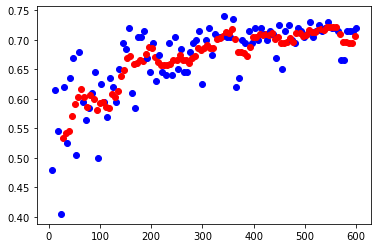

In [9]:
#set up the testing dataset
#.pep is the target variable
y_test = testing_df_dummy.pep
x_test = testing_df_dummy.drop(columns=['pep'])

scores = []
for i in range(1, 101):
  #set the scope for training dataset
  trainset=training_df_dummy.sample(frac=i/100)
  xl=trainset.drop(columns = ['pep'])
  yl=trainset.pep
  #creating the model with CT
  A_model = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(xl, yl)
  #get the testing accuracy using the model created
  myacc=accuracy_score(y_test, A_model.predict(x_test))
  #scatter plot for training sample up to 600
  plt.scatter(len(trainset), myacc, color = 'blue')

  #add an average line (every 5 records) to the scatter plot
  scores.append(myacc)
  if len(scores) >= 5:
    scoreLB = len(scores)-5
    meanScore = (sum(scores[scoreLB:])) / 5
    meanSample = (len(xl)-5 + len(xl)) / 2
    plt.scatter(meanSample, meanScore, color = 'red')

## Cross Validation

In [10]:
#cross validation over the entire sample of 600 records, with 200 folds
scores = cross_val_score(model, X, y, cv = 200)
print(scores.mean())

0.8383333333333333


## Information Gain/Mutual Informaiton

In [11]:
mi = list(mutual_info_classif(training_df_dummy.drop(columns = ['pep']), training_df_dummy.pep))
for m in mi:
  print(m)

0.0037030493841054835
0.0018936945902052749
0.03289458239529819
0.05201480324507868
0.0
0.003976192907248821
0.0
0.0
0.026967452328655606
0.0
0.00883945723007229
0.005647575446278585
0.0
0.0


## Pruning

In [12]:
#split sample data to training and validation sets
#split X to X_train, X_test 
#split y to y_train, y_test 
#X_train and y_train for training, X_test and y_test for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

#Look at the validation accuracy with different max_depth, stop at 5?, when a meaningful accuracy drop happened
for depth in reversed(range(2,11)):
  temp_model = DecisionTreeClassifier(criterion = 'entropy', max_depth=depth).fit(X_train, y_train)
  print(f"{depth}: Training: {accuracy_score(y_test, temp_model.predict(X_test))}, CV: {(cross_val_score(temp_model, X, y, cv = 10)).mean()}")

10: Training: 0.8131313131313131, CV: 0.8266666666666668
9: Training: 0.8434343434343434, CV: 0.8283333333333335
8: Training: 0.8585858585858586, CV: 0.8483333333333334
7: Training: 0.8181818181818182, CV: 0.86
6: Training: 0.8636363636363636, CV: 0.8683333333333334
5: Training: 0.8535353535353535, CV: 0.8433333333333334
4: Training: 0.8333333333333334, CV: 0.8283333333333334
3: Training: 0.7828282828282829, CV: 0.7366666666666666
2: Training: 0.5858585858585859, CV: 0.5933333333333334


In [13]:
#if use min_samples_leaf
#min_samples_leaf is the minimum number of samples required to be at a leaf node.
min_leaves_model = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 5).fit(X, y)
print(accuracy_score(y, min_leaves_model.predict(X)))

0.92


In [14]:
#split sample data to training and validation sets
#split X to X_train, X_test 
#split y to y_train, y_test 
#X_train and y_train for training, X_test and y_test for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

#Look at the validation accuracy with different min_samples_leaf, stop at 7?, when a meaningful accuracy drop happened
for leaves in reversed(range(2,11)):
  temp_model = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf=leaves).fit(X_train, y_train)
  print(f"{leaves}: Training: {accuracy_score(y_test, temp_model.predict(X_test))}, CV: {(cross_val_score(temp_model, X, y, cv = 10)).mean()}")

10: Training: 0.8787878787878788, CV: 0.875
9: Training: 0.8838383838383839, CV: 0.875
8: Training: 0.8838383838383839, CV: 0.8800000000000001
7: Training: 0.8232323232323232, CV: 0.8566666666666667
6: Training: 0.8535353535353535, CV: 0.8633333333333333
5: Training: 0.8383838383838383, CV: 0.865
4: Training: 0.8333333333333334, CV: 0.8466666666666667
3: Training: 0.8282828282828283, CV: 0.8550000000000001
2: Training: 0.8333333333333334, CV: 0.8483333333333334


## Precision/Recall

In [15]:
#split sample data to training and validation sets
X = training_df_dummy.drop(columns = ['pep'])
y = training_df_dummy.pep
#split sample data to training and validation sets
#split X to X_train, X_vali 
#split y to y_train, y_vali 
#X_train and y_train for training, X_vali and y_vali for validation
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.33)

#get the testing accuracy using training set (validation set not used)
y_test = testing_df_dummy.pep
X_test = testing_df_dummy.drop(columns=['pep'])
model = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 7, max_depth = 6).fit(X_train, y_train)
#make predictions based on our model
predictions = model.predict(X_test)

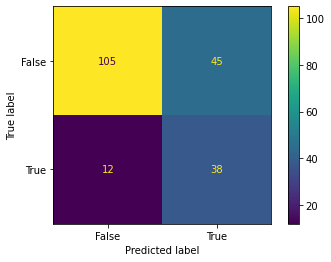

In [16]:
#create the confusion matrix with real test data y varible (T/F) and prediction (T/F)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [17]:
#show precision and recall
print("Precision:", precision_score(y_test, predictions))
print("Recall:", recall_score(y_test, predictions))

Precision: 0.4578313253012048
Recall: 0.76


In [18]:
#Overall CV, need to use training set because the model was fit with it
scores = cross_val_score(model, X, y, cv = 10)
print(scores.mean())

0.8633333333333333


## Cost Sensitivity


CV2: 0.8733333333333334
CV7: 0.8633333333333333


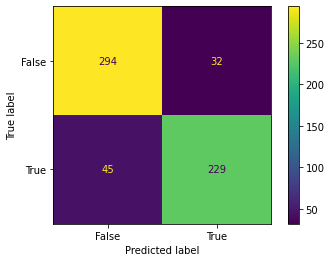

Precision of model with min leaf 2: 0.8773946360153256
Recall of model with min leaf 2: 0.8357664233576643
False negative = 45 and false positive = 32
Total cost = 365


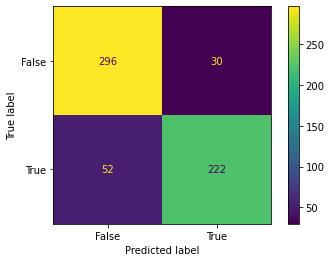

Precision of model with min leaf 7: 0.8809523809523809
Recall of model with min leaf 7: 0.8102189781021898
False negative = 52 and false positive = 30
Total cost = 352

Model with min_samples_leaf = 7 has a total cost of 352, which is better than the other model with a total cost of 365


In [19]:
from sklearn.model_selection import cross_val_predict


#split sample data to training and validation sets
X = training_df_dummy.drop(columns = ['pep'])
y = training_df_dummy.pep
#split sample data to training and validation sets
#split X to X_train, X_vali 
#split y to y_train, y_vali 
#X_train and y_train for training, X_vali and y_vali for validation
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.33)

#get the testing accuracy using training set (validation set not used)
y_test = testing_df_dummy.pep
X_test = testing_df_dummy.drop(columns=['pep'])


#min_samples_leaf = 2
model2 = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 2, max_depth = 6).fit(X_train, y_train)
#min_samples_leaf = 7
model3 = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 7, max_depth = 6).fit(X_train, y_train)
#Overall CV
scores2 = cross_val_score(model2, X, y, cv = 10)
scores7 = cross_val_score(model3, X, y, cv = 10)
#Very similar CV results, so will look for other ways to discern which model is better
print("CV2:", scores2.mean())
print("CV7:", scores7.mean())


#make predictions using cross validation based on our model
predictions2 = cross_val_predict(model2, X, y, cv = 10)
#create the confusion matrix with real test data y varible (T/F) and prediction (T/F)
cm2 = confusion_matrix(y, predictions2, labels=model2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=model2.classes_)
disp.plot()
plt.show()

#show precision and recall
print("Precision of model with min leaf 2:", precision_score(y, predictions2))
print("Recall of model with min leaf 2:", recall_score(y, predictions2))

#cost sensitivity
tn2 = cm2[0][0]
fp2 = cm2[0][1]
fn2 = cm2[1][0]
tp2 = cm2[1][1]
print(f'False negative = {fn2} and false positive = {fp2}')
total2 = int(fn2) + int(fp2)*10
print(f'Total cost = {total2}')


#make predictions using cross validation based on our model
predictions7 = cross_val_predict(model3, X, y, cv = 10)
#create the confusion matrix with real test data y varible (T/F) and prediction (T/F)
cm7 = confusion_matrix(y, predictions7, labels=model2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm7, display_labels=model3.classes_)
disp.plot()
plt.show()

#show precision and recall
print("Precision of model with min leaf 7:", precision_score(y, predictions7))
print("Recall of model with min leaf 7:", recall_score(y, predictions7))

#cost sensitivity
tn7 = cm7[0][0]
fp7 = cm7[0][1]
fn7 = cm7[1][0]
tp7 = cm7[1][1]
print(f'False negative = {fn7} and false positive = {fp7}')
total7 = int(fn7) + int(fp7)*10
print(f'Total cost = {total7}')


print()
#Find which model cost less
if total2 < total7:
  print(f'Model with min_samples_leaf = 2 has a total cost of {total2}, which is better than the other model with a total cost of {total7}')
elif total2 > total7:
  print(f'Model with min_samples_leaf = 7 has a total cost of {total7}, which is better than the other model with a total cost of {total2}')
else:
  print(f'Both model has the same cost with a total cost of {total2}')